In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE,SMOTENC  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings("ignore")
randomseed = 7

Using TensorFlow backend.


In [2]:
data1 = pd.read_csv("NextYearData_actualData_train.txt")
data2 = pd.read_csv("ThisYearData_actualData_train.txt")
data3 = pd.read_csv("ThisYearData_actualData_test.txt")

data4 = pd.read_csv("NextYearData_actualData_test.txt")

data5 = pd.read_csv("Predicted_NextYearData.txt")
data5.columns = data4.columns

data = pd.concat([data1, data2, data3])

print(data.shape)
data.head()

(74745, 16)


,Unnamed: 0,FIELD_1,FIELD_2,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,L100800,CLASS
0,0,1088387,20160715,6.73,148.0,29.4,38.0,5.6,3.0,0.0,1.0,0.0,0.0,53.0,115.0,1
1,1,137731,20161026,5.37,40.0,21.6,15.0,4.9,1.0,1.0,1.0,0.0,1.0,28.0,83.0,0
2,2,797147,20161123,5.76,176.0,25.9,91.0,4.7,3.0,1.0,0.0,0.0,0.0,43.0,111.0,1
3,3,1155086,20161129,6.13,124.0,29.2,20.0,5.5,1.0,0.0,0.0,1.0,1.0,57.0,98.0,0
4,4,887475,20140711,5.90,187.0,24.5,33.0,5.8,3.0,2.0,1.0,0.0,0.0,44.0,93.0,0


In [3]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

1122 20542 53081


In [4]:
diabetic_test = diabetic.sample(300, random_state=randomseed)
prediabetic_test = prediabetic.sample(300, random_state=randomseed)
normal_test = normal.sample(300, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(
    15 * diabetic_train.shape[0], random_state=randomseed
)
normal_train = normal.drop(normal_test.index).sample(
    15 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

In [5]:
# test.groupby(by='CLASS').size()

In [1]:
xtrain = train.iloc[:, 3:-2]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, 3:-2]
ytest = test.iloc[:, -1]

NameError: name 'train' is not defined

In [7]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler 
scaler = MinMaxScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)


In [8]:
# x = data.iloc[:, 3:-2]
# y = data.iloc[:, -1]

# xtrain, xtest, ytrain, ytest = train_test_split(
#     x, y, random_state=randomseed, test_size=0.2
# )

sm = SMOTENC(random_state=randomseed,categorical_features=[5,6,7,8,9],sampling_strategy='minority')
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res

# y_res2 = y_res.copy()
# from keras.utils import to_categorical
# y_res2 = to_categorical(y_res)

# xtrain, xtest, ytrain, ytest = train_test_split(
#     X_res, y_res2, random_state=randomseed, test_size=0.2
# )

Resampled dataset shape Counter({2: 10620, 1: 10620, 0: 10620})
10620 10620 10620
(31860, 11) (31860,)


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=15,
    max_features="auto"
)
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.7277777777777777


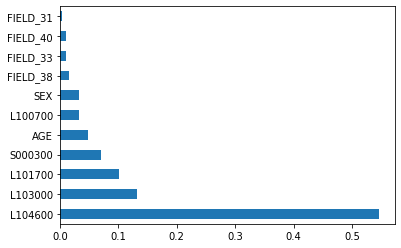

Index(['L104600', 'L103000', 'L101700', 'S000300', 'AGE', 'L100700', 'SEX',
       'FIELD_38', 'FIELD_33', 'FIELD_40', 'FIELD_31'],
      dtype='object')


In [10]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, 3:-2].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [11]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.773
Accuracy on test set: 0.728


,0,1,2
0,214,82,4
1,66,203,31
2,2,60,238


In [12]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.74       300
           1       0.59      0.68      0.63       300
           2       0.87      0.79      0.83       300

    accuracy                           0.73       900
   macro avg       0.74      0.73      0.73       900
weighted avg       0.74      0.73      0.73       900



In [13]:
# import xgboost as xgb
# from sklearn import metrics as m

# xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

# xgb_model.fit(xtrain, ytrain)

# y_pred = xgb_model.predict((xtest))

# print("accuracy \t", m.accuracy_score(ytest, y_pred))
# confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
# confmatrx.head()

In [14]:
# print(classification_report(ytest, y_pred))

In [15]:
# =====================================

tempdata=data5

diabetic = tempdata[tempdata.CLASS == 2]
prediabetic = tempdata[tempdata.CLASS == 1].sample(diabetic.shape[0],random_state=0)
normal = tempdata[tempdata.CLASS == 0].sample(diabetic.shape[0],random_state=0)

tempdata5=pd.concat([diabetic,prediabetic,normal])
tempdata5.iloc[:, 3:-2]=scaler.transform(tempdata5.iloc[:, 3:-2])

pred5 = rf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

0.6963906581740976


,0,1,2
0,108,47,2
1,45,103,9
2,1,39,117


In [16]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       157
           1       0.54      0.66      0.60       157
           2       0.91      0.75      0.82       157

    accuracy                           0.70       471
   macro avg       0.72      0.70      0.70       471
weighted avg       0.72      0.70      0.70       471



In [17]:
# ========================================================

In [18]:
import pickle

with open('DiabeticClassifierModelForNextYear_rf_model_SMOTE', 'wb') as f:
    pickle.dump(rf, f)

In [19]:
with open('DiabeticClassifierModelForNextYear_scaler_SMOTE', 'wb') as f:
    pickle.dump(scaler, f)